In [84]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import optuna
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
train_df = pd.read_csv('../dataset/train.csv')

In [107]:
train_df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,matched_make,matched_model
0,akron / canton,3995,2005.0,chevrolet,trailblazer lt,good,6 cylinders,gas,166000.0,clean,automatic,4wd,sedan,white,oh,2021-04-26T21:39:48-0400,chevrolet,Trailblazer FWD
1,raleigh / durham / CH,9931,2014.0,chevrolet,cruze,good,4 cylinders,gas,95550.0,clean,automatic,fwd,sedan,red,nc,2021-04-29T16:00:06-0400,chevrolet,Cruze
2,houston,24999,2013.0,ram,1500 sport,excellent,6 cylinders,gas,5000.0,clean,automatic,4wd,truck,black,tx,2021-05-01T09:19:25-0500,ram,1500 Classic 2WD
3,austin,19400,2011.0,toyota,4runner,good,6 cylinders,gas,116309.0,clean,automatic,4wd,SUV,white,tx,2021-04-30T13:53:09-0500,toyota,4Runner 4WD
4,rhode island,1500,2009.0,nissan,rogue,good,6 cylinders,gas,168.0,clean,automatic,4wd,sedan,white,ri,2021-04-06T13:02:14-0400,nissan,Rogue Sport FWD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,el paso,8500,2016.0,chrysler,town country,good,6 cylinders,gas,89498.0,rebuilt,automatic,4wd,van,white,tx,2021-05-03T09:02:43-0600,chrysler,Town and Country
7714,ann arbor,5400,1996.0,ram,1500 4wd,good,8 cylinders,gas,226000.0,clean,automatic,4wd,truck,white,mi,2021-04-15T18:28:31-0400,ram,1500 4WD
7715,norfolk / hampton roads,3200,2000.0,ford,explorer eddie bauer 4x4,good,6 cylinders,gas,174000.0,clean,automatic,4wd,SUV,red,va,2021-04-30T12:20:22-0400,ford,EXP
7716,oklahoma city,16900,2017.0,volvo,s60,good,6 cylinders,gas,55000.0,clean,automatic,4wd,sedan,white,ok,2021-04-20T21:20:25-0500,volvo,S60


In [112]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7718 entries, 0 to 7717
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   region         7718 non-null   object 
 1   price          7718 non-null   int64  
 2   year           7718 non-null   float64
 3   manufacturer   7718 non-null   object 
 4   model          7718 non-null   object 
 5   condition      7718 non-null   object 
 6   cylinders      7718 non-null   object 
 7   fuel           7718 non-null   object 
 8   odometer       7718 non-null   float64
 9   title_status   7718 non-null   object 
 10  transmission   7718 non-null   object 
 11  drive          7718 non-null   object 
 12  type           7718 non-null   object 
 13  paint_color    7718 non-null   object 
 14  state          7718 non-null   object 
 15  posting_date   7718 non-null   object 
 16  matched_make   7718 non-null   object 
 17  matched_model  7718 non-null   object 
dtypes: float

In [ ]:
train_df.drop(columns=['manufacturer', 'model'], inplace=True)

In [115]:
numeric_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

categorical_columns = train_df.select_dtypes(include=['object']).columns

print(f'Numeric >> {numeric_columns}\n')
print(f'Categorical >> {categorical_columns}')

Numeric >> Index(['price', 'year', 'odometer'], dtype='object')

Categorical >> Index(['region', 'condition', 'cylinders', 'fuel', 'title_status',
       'transmission', 'drive', 'type', 'paint_color', 'state', 'posting_date',
       'matched_make', 'matched_model'],
      dtype='object')


In [ ]:
encoded_train_df = train_df.copy()

encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    le.fit(encoded_train_df[col])
    encoded_train_df[col] = le.transform(train_df[col])
    encoders[col] = le

In [128]:
encoded_train_df

,region,price,year,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,posting_date,matched_make,matched_model
0,2,3995,2005.0,2,5,2,166000.0,0,0,0,9,10,35,4983,7,865
1,273,9931,2014.0,2,3,2,95550.0,0,0,1,9,8,27,6026,7,281
2,143,24999,2013.0,0,5,2,5000.0,0,0,0,10,0,43,6910,30,5
3,18,19400,2011.0,2,5,2,116309.0,0,0,0,0,10,43,6517,34,60
4,278,1500,2009.0,2,5,2,168.0,0,0,0,9,10,39,327,27,710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7713,95,8500,2016.0,2,5,2,89498.0,3,0,0,11,10,43,7867,8,861
7714,9,5400,1996.0,2,6,2,226000.0,0,0,0,10,10,22,2086,30,4
7715,229,3200,2000.0,2,5,2,174000.0,0,0,0,0,8,45,6458,11,329
7716,246,16900,2017.0,2,5,2,55000.0,0,0,0,9,10,36,3099,36,726


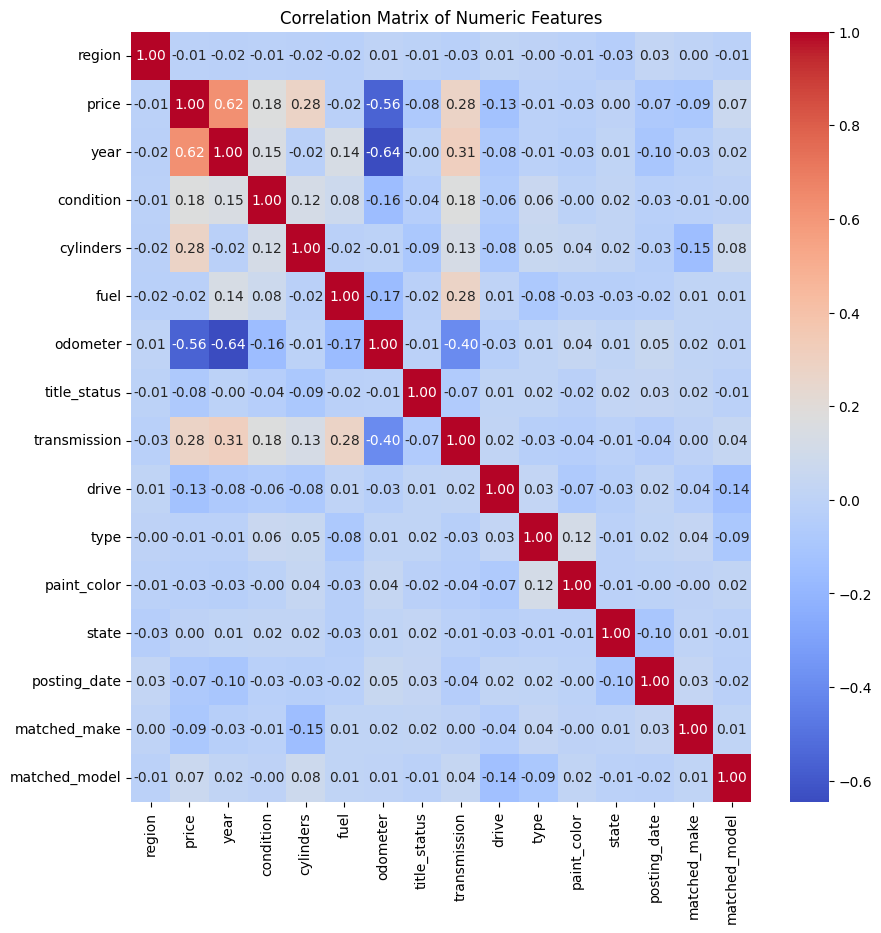

In [131]:
# Compute correlation matrix
correlation_matrix = encoded_train_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [133]:
X = encoded_train_df.drop(columns=['price'])
y = encoded_train_df['price']

In [134]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # Use 5-fold cross-validation
    score = cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score  # Optuna minimizes, so negate RMSE

In [135]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-04-25 02:14:20,898] A new study created in memory with name: no-name-e5c88e21-1b31-4a3d-b508-83f905ceefd7
[I 2025-04-25 02:14:21,985] Trial 0 finished with value: 7882.833410507161 and parameters: {'n_estimators': 76, 'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 18}. Best is trial 0 with value: 7882.833410507161.
[I 2025-04-25 02:14:24,049] Trial 1 finished with value: 7696.996178442552 and parameters: {'n_estimators': 140, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 18}. Best is trial 1 with value: 7696.996178442552.
[I 2025-04-25 02:14:26,730] Trial 2 finished with value: 7393.28070793126 and parameters: {'n_estimators': 138, 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 7}. Best is trial 2 with value: 7393.28070793126.
[I 2025-04-25 02:14:28,134] Trial 3 finished with value: 7289.255928211191 and parameters: {'n_estimators': 59, 'max_depth': 23, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 3 with value: 7289

In [136]:
print("Best trial:")
trial = study.best_trial
print(f"  RMSE: {trial.value}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 7099.529467220777
  Params:
    n_estimators: 206
    max_depth: 30
    min_samples_split: 3
    min_samples_leaf: 1


In [137]:
best_params = trial.params
model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
model.fit(X, y)

RandomForestRegressor(max_depth=30, min_samples_split=3, n_estimators=206,
                      n_jobs=-1, random_state=42)

In [140]:
joblib.dump(model, '../models/random_forest_model.pkl')

['../models/random_forest_model.pkl']